# 学习曲线与验证曲线

本文主要介绍了学习曲线(lenaring curve)和验证曲线(validation curve)  
绘制学习曲线和验证曲线在机器学习中非常有帮助，能够帮助我们更好的调整模型

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt

np.random.seed(1024)

## 学习曲线(Learning Curve)

学习曲线绘制了数据规模与模型性能之间的关系，可以帮助我们观察随着数据规模增加，模型性能的表现，判断数据规模增加是否能帮助改善模型性能，同时也能观察模型的拟合情况

下面将通过绘制不同阶数数据下的线性回归模型的学习曲线作为示例

根据如下函数来生成模拟数据

$y = x^2 + 0.1x + 0.5 + \varepsilon$, 其中$\varepsilon \sim N(0, 0.5)$

In [2]:
def true_linear_fun(X):
    return 0.5 + 0.1 * X.flatten() + X.flatten()**2

data_size = 200

X = np.random.uniform(-2, 2, size=(data_size, 1))
y = true_linear_fun(X) + np.random.normal(scale=0.5, size=data_size)

定义一个可以获取不同阶数下数据的方法

In [3]:
def get_X_high_degree(X, degree=2):
    if degree < 2:
        return X
    X_high_degree = X.copy()
    for i in range(2, degree + 1):
        X_high_degree = np.hstack((X_high_degree, X**i))
    return X_high_degree

In [4]:
X2 = get_X_high_degree(X, degree=2)
X8 = get_X_high_degree(X, degree=8)

绘制不同阶数下，模型的学习曲线，来比较不同阶数下，线性回归模型的性能

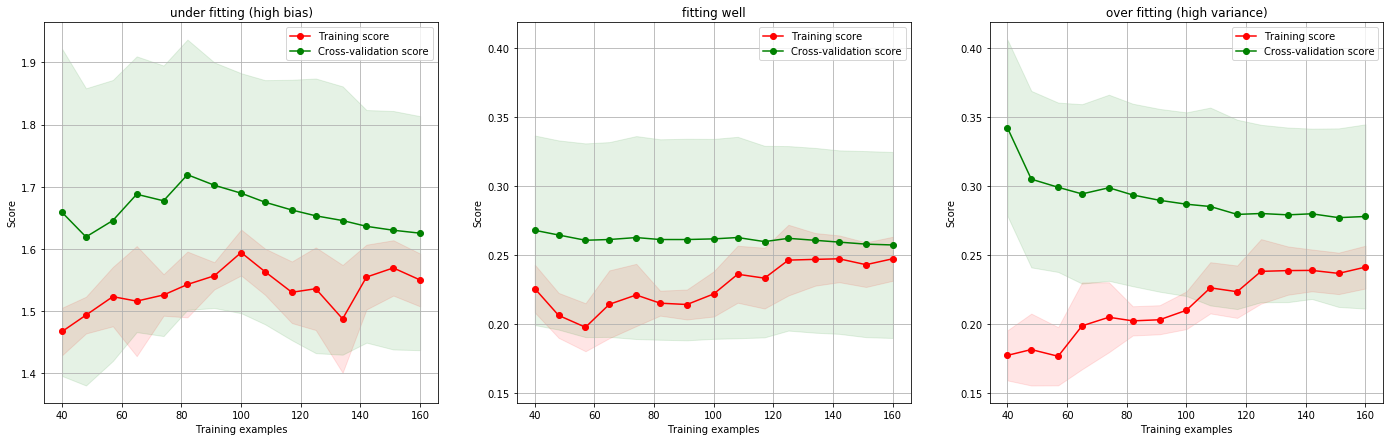

In [5]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression

# 线性回归模型
lin_reg = LinearRegression()

cv = 5
mse = make_scorer(mean_squared_error)

fig = plt.figure(figsize = (24, 7))
# 一阶线性回归模型
ax = fig.add_subplot(1, 3, 1)
skplt.estimators.plot_learning_curve(lin_reg, X, y, train_sizes=np.linspace(0.25, 1.0, 15), 
                                     cv=cv, scoring=mse, ax=ax, title='under fitting (high bias)', 
                                     random_state=1024)
# 二阶线性回归模型
ax = fig.add_subplot(1, 3, 2)
skplt.estimators.plot_learning_curve(lin_reg, X2, y, train_sizes=np.linspace(0.25, 1.0, 15), 
                                     cv=cv, scoring=mse, ax=ax, title='fitting well', random_state=1024)
# 高阶线性回归模型
ax = fig.add_subplot(1, 3, 3, sharey=ax)
skplt.estimators.plot_learning_curve(lin_reg, X8, y, train_sizes=np.linspace(0.25, 1.0, 15), 
                                     cv=cv, scoring=mse, ax=ax, title='over fitting (high variance)', 
                                     random_state=1024)
plt.show()

相较于其他两幅图，左边的图的`mse`较高，模型表现为欠拟合；而右边的图中，训练`mse`和测试`mse`差距较大，模型表现为过拟合  
从中间的图中可以观察到数据量在超过120时，训练`mse`和测试`mse`差距较小，模型表现的已经较为稳定了，可以说明数据量在大于120时，加入更多的数据对于模型的提升已经非常小了

绘制不同阶数下的线性回归线

In [6]:
lin_reg1 = LinearRegression()
lin_reg1.fit(X, y)

lin_reg2 = LinearRegression()
lin_reg2.fit(X2, y)

lin_reg8 = LinearRegression()
lin_reg8.fit(X8, y)

x_range = np.linspace(-2, 2, 100).reshape((-1, 1))
x_range2 = get_X_high_degree(x_range, degree=2)
x_range8 = get_X_high_degree(x_range, degree=8)

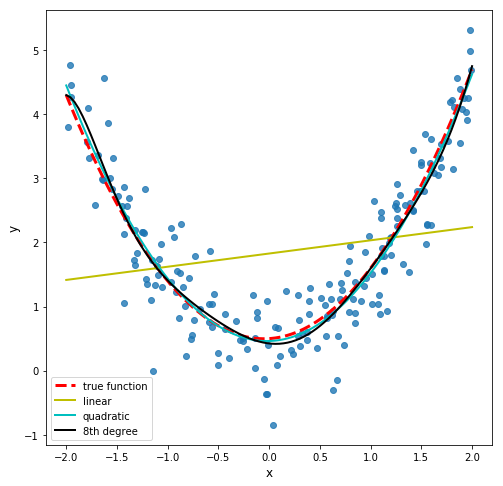

In [7]:
plt.figure(figsize=(8, 8))
plt.scatter(X, y, alpha=0.8)
plt.plot(x_range, true_linear_fun(x_range), c='r', linestyle='--', linewidth=3, label='true function')
plt.plot(x_range, lin_reg1.predict(x_range), c='y', linewidth=2, label='linear')
plt.plot(x_range, lin_reg2.predict(x_range2), c='c', linewidth=2, label='quadratic')
plt.plot(x_range, lin_reg8.predict(x_range8), c='k', linewidth=2, label='8th degree')
plt.xlabel('x', fontsize='large')
plt.ylabel('y', fontsize='large')
plt.legend()
plt.show()

## 验证曲线(Validation Cureve)

验证曲线绘制了不同超参数与模型性能的关系，可以帮助我们更好的调优参数，观察模型的拟合情况

接着使用学习曲线一节中使用的数据，通过验证曲线来选择模型的阶数

In [8]:
from sklearn.model_selection import cross_validate
degree_range = range(1, 10)

train_mse = []
test_mse = []

# 通过交叉验证来计算不同阶数下的训练mse和测试mse
for d in degree_range:
    X_input = get_X_high_degree(X, degree=d)
    scores = cross_validate(lin_reg, X_input, y, scoring=mse, cv=5, return_train_score=True)
    train_mse.append(np.mean(scores['train_score']))
    test_mse.append(np.mean(scores['test_score']))

绘制验证曲线

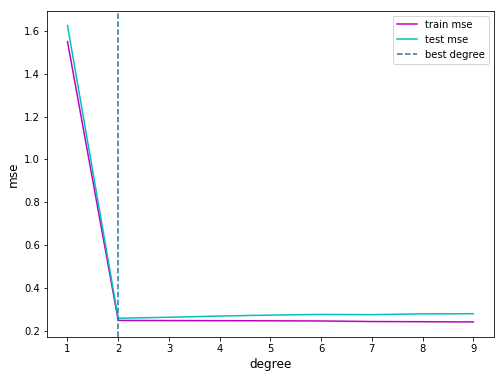

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(degree_range, train_mse, label='train mse', c='m')
plt.plot(degree_range, test_mse, label='test mse', c='c')
plt.xlabel('degree', fontsize='large')
plt.ylabel('mse', fontsize='large')
# 测试mse最小时的阶数提示线
plt.axvline(x=np.argmin(test_mse) + 1, linestyle='--', label='best degree')
plt.legend()
plt.show()

从验证曲线上可以看到，阶数为2时，测试`mse`达到最小，而随着当阶数增大时，训练`mse`逐渐下降的，但测试`mse`逐渐上升，说明模型产生了过拟合，因此选定模型的阶数为2

下面的示例是通过验证曲线来选定`Lasso`回归的超参数(惩罚项参数)$\alpha$

模拟产生一个含有15个特征的数据，但是只用到前2个特征来计算y

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

X = np.random.randn(100, 15)
y = 3 + 2 * X[:, 0] + X[:, 1] + np.random.randn(100)
params = {'alpha': [2**i for i in range(-8, 1)]}
lasso_reg = Lasso()
lasso_cv = GridSearchCV(lasso_reg, param_grid=params, 
                        scoring={'mse': mse, 'neg_mean_squared_error': 'neg_mean_squared_error'}, 
                        refit='neg_mean_squared_error', return_train_score=True)
lasso_cv.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=True,
       scoring={'mse': make_scorer(mean_squared_error), 'neg_mean_squared_error': 'neg_mean_squared_error'},
       verbose=0)

绘制超参数$\alpha$与训练和测试mse的验证曲线

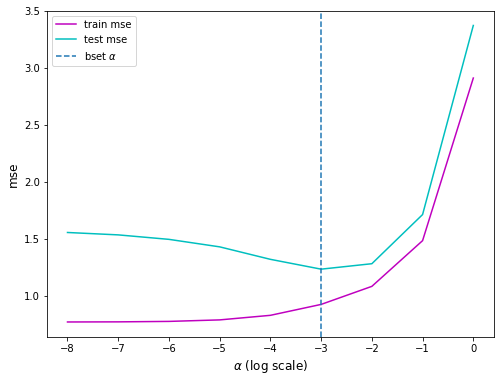

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(np.log2(params['alpha']), lasso_cv.cv_results_['mean_train_mse'], label='train mse', c='m')
plt.plot(np.log2(params['alpha']), lasso_cv.cv_results_['mean_test_mse'], label='test mse', c='c')
plt.axvline(np.log2(lasso_cv.best_params_['alpha']), linestyle='--', label=r'bset $\alpha$')
plt.xlabel(r'$\alpha$ (log scale)', fontsize='large')
plt.ylabel('mse', fontsize='large')
plt.legend()
plt.show()

In [12]:
lasso_cv.best_params_

{'alpha': 0.125}

观察验证曲线可以看到，$\alpha$为0.125时，测试mse达到最小；小于0.125时，训练mse下降，但是测试mse上升，模型出现过拟合，而当大于0.125时，训练和测试mse都上升，模型存在欠拟合；因此，这里选定的$\alpha$为0.125